# Simple Cloud Disk

## Introduction

This website is used to verify the following vulnerabilities:

1.Exposure of Sensitive Information to an Unauthorized Actor: There is a vulnerability in the file list query interface that allows unauthorized users to access the files of other users by modifying the userID.

2.Exposure of Information Through Directory Listing: Some sensitive directories display directory listings, exposing users' personal information.

3.Server-Side Request Forgery (SSRF): The resource downloading feature does not protect against SSRF vulnerabilities, allowing attackers to fetch arbitrary Internet resources.

4.Cross-Site Request Forgery (CSRF): The feature of remotely downloading resources is not protected against CSRF vulnerabilities, enabling attackers to design forms that POST to this interface, allowing victims to download files specified by the attacker without authorization.

To make the demo easy, we use Docker Compose for arranging the project, so it can make one click fast startup for the example environment.



## Environment Requirements

1. Docker
2. Docker Compose (version >= `3.9`)
3. Python (version >= `3.8`)


## Project Structure

- `controllers/`: The controllers of server
- - `controllers/users.js`: The `users` controller of server
- - `controllers/files.js`: The `files` controller of server
- `data/`: The directory for data
- `data/accounts.json`: The `json` file which records the username and password of all the users
- `data/{username}/`: The data directory for `username` which storage the files of the user
- `nginx/`: The directory for reverse proxy server `nginx`
- `nginx/nginx.conf`: The configuration file of `nginx`
- `node_modules/`: The dependencies of Node.js
- `app.js`: The `entry` source code of the server
- `package.json` or `package-json.json`: The description file for Node.js
- `routes.js`: The source of the router for the server
- `utils.js`: The source of the utility for the server

## Run the server

The example is constructed by docker compose. So it is quiet easy to run the server.

```bash
docker-compose up --build -d
```

> The server will build and run in the background.


In [ ]:
!docker-compose up --build -d

The port of the example server is `8081`.

You can broswer the index page of the example server.

You need to log in firstly.

> Example users:
>
> `username`: `alice`
>
> `password`: `alice`

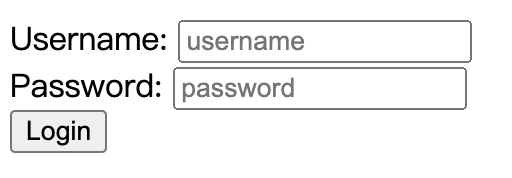

After logging in, you can see all the files of your driver.

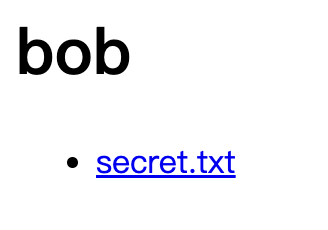

## Test Cases

### Exposure of Sensitive Information to an Unauthorized Actor

Step 1: Access the file of Bob

In [1]:
!curl http://localhost:8081/api/files/bob/secret.txt

This is a secret.

# CWE-548: Exposure of Information Through Directory Listing

You can find that the secret of Bob can be downloaded. It has the vulnerability of Exposure of Information Through Directory Listing.

Because it does not have any access control in function `downloadFile` of `files` controller.

```javascript
const downloadFile = async (ctx) => {
    const { username, filename } = ctx.request.params;

    ctx.type = 'application/octet-stream';
    ctx.attachment(filename);
    ctx.body = fs.createReadStream(`./data/attachments/${username}/${filename}`);
}
```

Step 2: Fix the vulnerability

We should validate the permission of users. Make sure that only the users can access their own files.

A simple way is adding a validator in function `downloadFile` just like that:

```javascript
const downloadFile2 = async (ctx) => {
    // Get the params from query
    const { username, filename } = ctx.request.params;

    // Get the username from JWT
    let my_username;
    try {
        const decoded = jwt.verify(ctx.request.headers['x-token'] || '', process.env['JWT_KEY']);

        my_username = decoded.username;
    } catch (e) {
        // throw new Error('Please log in!');
    }

    // Verify the permission
    if (username !== my_username) {
        ctx.status = 403;
        return ctx.body = 'Forbidden!'
    }

    ctx.type = 'application/octet-stream';
    ctx.attachment(filename);
    ctx.body = fs.createReadStream(`./data/attachments/${username}/${filename}`);
}
```

Let check the mitigation:

In [5]:
!curl http://localhost:8081/api/files2/bob/secret.txt

Forbidden!

"Foribidden!" shows that the current user does not have permission to access this resource, which confirms that the vulnerability has been resolved.

### Exposure of Information Through Directory Listing

Step 1: Access the attachment path

In [6]:
!open http://127.0.0.1:8081/attachment/

You can find that the structure of the server's attachment directory can be queried.

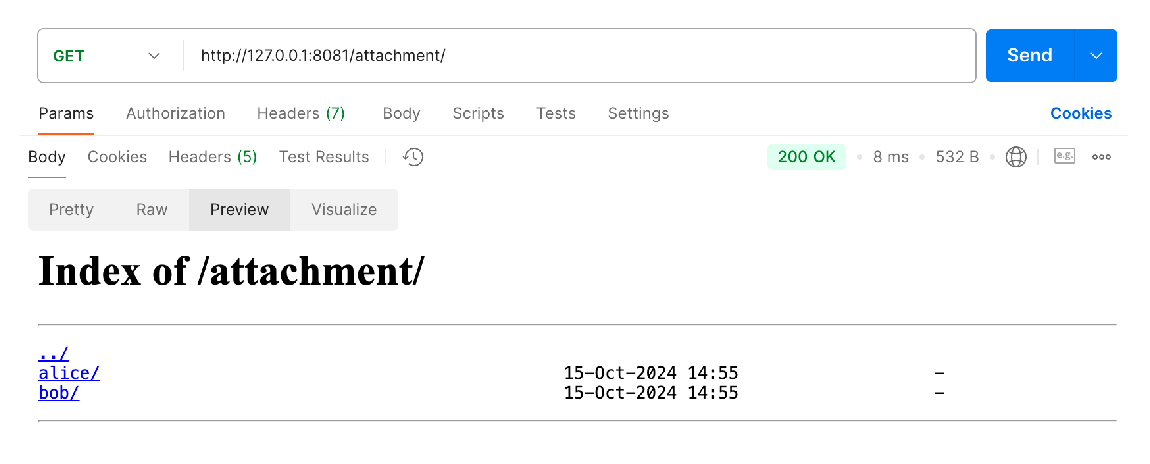

Step 2: Fix the vulnerability

We should remove the configuration of "autoindex on;" in the path of "/attachment".

The path of nginx configuration is `simple-cloud-disk/nginx/nginx.conf`

```nginx
        location /attachment/ {
            alias   /var/www/attachments/;
            # autoindex on;  # remove this 
        }
```

Remember! You need to save the save of configuration and restart the server.

In [ ]:
!docker-compose up --build -d

Try again to visit the page. You can find that the page ONLY shows "403 Forbidden" now. The vulnerability has been resolved.

In [ ]:
!open http://127.0.0.1:8081/attachment/

### Server-Side Request Forgery (SSRF)

Step 1: Download internal resource

In [11]:
!curl "http://localhost:8081/api/download-remote?url=http://localhost:8080/leak"

This is a leak page

You can find that this interface can download the file of `http://localhost:8080/leak`. In fact, this hostname can not be accessed by external users.

Step 2: Fix SSRF

Use the "ssrf-req-filter" library as a tool to filter requests. The code is like that:

```javascript
const ssrfFilter = require('ssrf-req-filter');

const response = await axios({
    method: 'GET',
    url: url,
    responseType: 'arraybuffer',
    timeout: 30000,

    // Add SSRF protection agents
    httpAgent: ssrfFilter(url),
    httpsAgent: ssrfFilter(url)
});
```

Let check the mitigation:

In [12]:
!curl "http://localhost:8081/api/download-remote2?url=http://localhost:8080/leak"

{"error":"Failed to fetch remote file"}

You can easily find that we can not download that file after fixing.  The vulnerability has been resolved.

### Cross-Site Request Forgery (CSRF)

Step 1: Try to attack


In [ ]:
!open http://127.0.0.1:8082/download.html

You can enter the this page of downloading remote resources. You can input the URL like `https://www.cityu.edu.hk/robots.txt` to download this file of the URL.

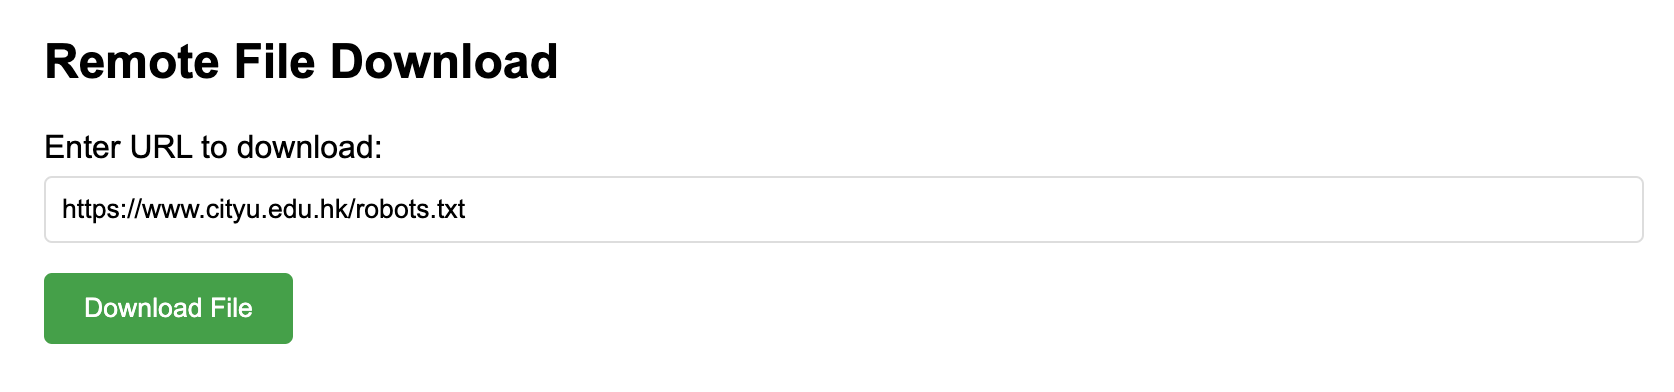

In fact, this interface is only allowed for `http://127.0.0.1:8081`, not `http://127.0.0.1:8082/`.

Attackers can use this form to attack you by CSRF.

Step 2: Fix it by filtering referer

The one method to fix the bug is filter referer. That means ONLY the white-list domains can access this interface.

So we need to add a validator middleware like `checkReferer` in `files.js`.

```javascript
const checkReferer = async (ctx, next) => {
    const referer = ctx.request.headers['referer'];
    const allowedReferer = 'http://127.0.0.1:8081';

    if (!referer || !referer.startsWith(allowedReferer)) {
        ctx.status = 403;
        ctx.body = { error: 'Access denied: Invalid referer' };
        return;
    }

    await next();
};
```

You can visit `http://127.0.0.1:8082/download2.html` to verify.

In [ ]:
!open http://127.0.0.1:8082/download2.html

You can find that you can only get the response of `{"error":"Access denied: Invalid referer"}`. Because the source of request is invalid.

But this method can not defend the CSRF of same origin. So we need to use CSRF Token to increase the security.

Step 3: Fix it by CSRF Token

For requests that modify state such as form submissions, it is recommended that all user requests include a CSRF token. This token should be dynamically generated and embedded in the HTML page of the website, making it random and unpredictable. Since attackers cannot obtain this token in advance, it provides a strong defense against CSRF attacks.

```javascript
const crypto = require('crypto');

// Store CSRF tokens (in production you might want to use Redis instead)
const csrfTokens = new Map();

// Generate CSRF token middleware
const generateCsrfToken = async (ctx, next) => {
    // Generate a random token
    const token = crypto.randomBytes(32).toString('hex');
    
    // Store the token with a timestamp (for cleanup)
    csrfTokens.set(token, {
        timestamp: Date.now(),
        used: false
    });

    // Clean up old tokens (optional)
    const ONE_HOUR = 3600000;
    for (const [key, value] of csrfTokens.entries()) {
        if (Date.now() - value.timestamp > ONE_HOUR || value.used) {
            csrfTokens.delete(key);
        }
    }

    ctx.state.csrfToken = token;
    await next();
};

// Verify CSRF token middleware
const verifyCsrfToken = async (ctx, next) => {
    const token = ctx.request.query.csrf_token;

    if (!token || !csrfTokens.has(token)) {
        ctx.status = 403;
        ctx.body = { error: 'Invalid or missing CSRF token' };
        return;
    }

    const tokenData = csrfTokens.get(token);
    if (tokenData.used) {
        ctx.status = 403;
        ctx.body = { error: 'Token has already been used' };
        return;
    }

    // Mark token as used
    tokenData.used = true;
    await next();
};
```

You can visit `http://localhost:8082/download4.html` to verify.

In [ ]:
!open http://localhost:8082/download4.html

Yes, you will get the response `{"error":"Invalid or missing CSRF token"}`. Beacuse the CSRF middleware detects the attack.

You can visit `http://localhost:8081/api/download4` to check the page with CSRF Token. You will find that you can download file in this page. Because `csrf_token` is set when the page is rendering on the server. The token is like `0f9915da0c835db78586d290c72338d60a77c791a8ba852f1fca3baf91ec45b5`. It is a random number to defend the attacker to obtain it.

In [ ]:
!open http://localhost:8081/api/download4